In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision import datasets, models
import matplotlib.pyplot as plt
import time
import os
import copy
import argparse
import random
import numpy as np
import warnings
import torch.utils.data as data
from PIL import Image


plt.ion()  # interactive mode
warnings.filterwarnings('ignore')

In [2]:
class RotationDataset(Dataset):

    def __init__(self, split, unlabelled_root_dir, labelled_root_dir, preTransform=None, postTransform=None):
        self.unlabelled_root_dir = unlabelled_root_dir
        self.labelled_root_dir = labelled_root_dir

        # Output of pretransform should be PIL images
        self.preTransform = preTransform
        self.postTransform = postTransform
        self.split = split
        self.labelled_data_dir = labelled_root_dir + '/' + split
        self.labelled_dataset = datasets.ImageFolder(self.labelled_data_dir, self.preTransform)
        '''
        if split == 'train':
            self.unlabelled_dataset = datasets.ImageFolder(self.unlabelled_root_dir, self.preTransform)
            self.dataset = ConcatDataset([self.labelled_dataset, self.unlabelled_dataset])
        else:
            self.dataset = self.labelled_dataset
        '''
        self.dataset = self.labelled_dataset
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img0, clss = self.dataset[idx]
        rot_class = np.random.randint(4)
        rot_angle = rot_class * 90

        rot_img = img0.rotate(rot_angle)
        if self.postTransform:
            sample = self.postTransform(rot_img)
        else:
            sample = transforms.ToTensor(rot_img)
        return sample, rot_class


In [3]:
# General Code for supervised train
def train_model(model, criterion, optimizer, scheduler, device, checkpoint_path, f, verbIter, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{} \n'.format(epoch, num_epochs - 1))
        
        f.write('Epoch {}/{} \n'.format(epoch, num_epochs - 1))
        f.write('-' * 10)
        f.write('\n')
        f.flush()

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()   # Set model to training mode
            else:
                model.eval()    # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            n_samples = 0

            end = time.time()

            # Iterate over data.
            for batch_num, (inputs, labels) in enumerate(dataloaders[phase]):

                data_time = time.time() - end
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                batchSize = inputs.size(0)
                n_samples += batchSize

                # forward
                # track history if only in train
                forward_start_time = time.time()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()
                forward_time = time.time() - forward_start_time

                # statistics
                running_loss += loss.item() * inputs.size(0)
                pred_top_1 = torch.topk(outputs, k=1, dim=1)[1]
                running_corrects += pred_top_1.eq(labels.view_as(pred_top_1)).int().sum().item()

                if batch_num+1 % verbIter == 0:
                    # Metrics
                    top_1_acc = running_corrects / n_samples
                    epoch_loss = running_loss / n_samples
                    print('{} Loss: {:.4f} Top 1 Acc: {:.4f} \n'.format(phase, epoch_loss, top_1_acc))
                    print('Full Batch time: {} , Data load time: {} , Forward time: {}\n'.format(time.time() - end,
                                                                                                   data_time,
                                                                                                   forward_time))

                    f.write('{} Loss: {:.4f} Top 1 Acc: {:.4f} \n'.format(phase, epoch_loss, top_1_acc))
                    f.write('Full Batch time: {} , Data load time: {} , Forward time: {}\n'.format(time.time() - end,
                                                                                                   data_time,
                                                                                                   forward_time))
                    f.flush()

                end = time.time()

            # Metrics
            top_1_acc = running_corrects / n_samples
            epoch_loss = running_loss / n_samples
            print('{} Loss: {:.4f} Top 1 Acc: {:.4f} \n'.format(phase, epoch_loss, top_1_acc))

            f.write('{} Loss: {:.4f} Top 1 Acc: {:.4f} \n'.format(phase, epoch_loss, top_1_acc))
            f.flush()

            # deep copy the model
            if phase == 'test' and top_1_acc > best_acc:
                best_acc = top_1_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            torch.save(model.state_dict(), '%s/net_epoch_%d.pth' % (checkpoint_path, epoch))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s \n'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f} \n'.format(best_acc))
    f.write('Training complete in {:.0f}m {:.0f}s \n'.format(time_elapsed // 60, time_elapsed % 60))
    f.write('Best test Acc: {:4f} \n'.format(best_acc))
    f.flush()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [4]:
parser = argparse.ArgumentParser()
parser.add_argument('--lr', type=float, default=0.001, help='learning rate, default=0.001')
parser.add_argument('--netCont', default='', help="path to net (to continue training)")
parser.add_argument('--manualSeed', type=int, help='manual seed')

# opt, unknown = parser.parse_known_args()
opt = parser.parse_args(args=[])
opt.lr = 0.005
opt.manualSeed = 2077
# opt.netCont = './models/net_epoch_56.pth'

In [5]:
out_dir = './Step_01_Rot/models'        #'./test'
log_out_dir = './Step_01_Rot/logs'      #'./test'

try:
    os.makedirs(out_dir)
    os.makedirs(log_out_dir)
except OSError:
    pass

In [6]:
f = open("{}/training_logs.txt".format(log_out_dir), "w+")
if opt.manualSeed is None:
    opt.manualSeed = random.randint(1, 10000) 
f.write("Random Seed: {} \n".format(opt.manualSeed))
random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)

In [7]:
cudnn.benchmark = True
image_size = (224, 224)   # (224, 224)
# labelled_data_root = './Kaggle265/split{}'.format(0)
labelled_data_root = './Kaggle265/'     # 'E:/Laplace/Dataset/cifar10'
unlabelled_data_root = './null/'        # 'E:/Laplace/Dataset/cifar10'
batch_size = 64
epochs = 10

In [8]:
# Initiate dataset and dataset transform
data_pre_transforms = {
    'train': transforms.Compose([
        transforms.Resize(image_size),
        transforms.RandomHorizontalFlip(),
    ]),
    'test': transforms.Compose([
        transforms.Resize(image_size),
    ]),
}
data_post_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.6086, 0.4920, 0.4619], std=[0.2577, 0.2381, 0.2408])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.6086, 0.4920, 0.4619], std=[0.2577, 0.2381, 0.2408])
    ]),
}

In [9]:
image_datasets = {x: RotationDataset(x, unlabelled_data_root, labelled_data_root, data_pre_transforms[x], data_post_transforms[x]) for x in
                  ['train', 'test']}
assert image_datasets
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, pin_memory=True, shuffle=True,
                                   num_workers=4) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

In [10]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# use_cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
f.write("using " + str(device) + "\n")
f.flush()

In [11]:
# Model Initialization
model_ft = models.resnet18(pretrained=True)
# print(model_ft)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 4)
print(model_ft)

if torch.cuda.device_count() > 1: 
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model_ft = nn.DataParallel(model_ft)
model_ft = model_ft.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
# model_dict = torch.load('net.pth.tar').state_dict()
model_dict = model_ft.state_dict()
dict_name = list(model_dict)
# for i, p in enumerate(dict_name):
#     print(i, p)

for i, p in enumerate(model_ft.parameters()):
    if i < 1:
        # Only train FC
        p.requires_grad = True
        p[0,0,0,0].detach()

        print(p[0,0,0,0])
        print(p)




tensor(-0.0104, device='cuda:0', grad_fn=<SelectBackward>)
Parameter containing:
tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
            1.7083e-02, -1.2694e-02],
          [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
           -1.2907e-01,  3.7424e-03],
          [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
            2.5632e-01,  6.3573e-02],
          ...,
          [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
           -4.2058e-01, -2.5781e-01],
          [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
            3.9359e-01,  1.6606e-01],
          [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
           -8.2230e-02, -5.7828e-03]],

         [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
            6.6221e-04, -2.5743e-02],
          [ 4.5687e-02,  3.3603e-02, -1.0453e-01,  ..., -3.1253e-01,
           -1.6051e-01, -1.2826e-03],
          [-8.3730e-04,  9.8420e-02,  4.0210e-

In [13]:
if opt.netCont != '':
    model_ft.load_state_dict(torch.load(opt.netCont, map_location=device))
    print('Loaded state and continuing training')
    f.write('Loaded state and continuing training')

# Model trainer
criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(
    [
        {'params': (p for name, p in model_ft.named_parameters() if 'bias' not in name), 
            'lr': opt.lr, 'momentum': 0.9, 'nesterov': True, 'weight_decay': 1e-4},
        {'params': (p for name, p in model_ft.named_parameters() if 'bias' in name), 
            'lr': opt.lr, 'momentum': 0.9, 'nesterov': True, 'weight_decay': 0.}
    ]   # , lr=1e-3, momentum=0.8, weight_decay=0.001
)
# optimizer_conv = optim.SGD(model_ft.parameters(), lr=opt.lr, momentum=0.9, nesterov=True, weight_decay=0.005)
exp_lr_scheduler = lr_scheduler.MultiStepLR(optimizer_conv, milestones=[50, 100, 150], gamma=0.25)
model_ft = train_model(model_ft, criterion, optimizer_conv, exp_lr_scheduler, device, out_dir, f, 10,
                       num_epochs=epochs)


Epoch 0/9 



RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [13]:
torch.save(model_ft.state_dict(), out_dir+'/Rotation_pretrained.pth')
f.close()

In [14]:
# 输出图像的函数
def imshow(img):
    # img = img.to('cpu')
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_img(model, num_pics):
    model.eval()  # Set model to evaluate mode
    # Iterate over data.
    for batch_num, (inputs, labels) in enumerate(dataloaders['train']):
        # inputs = inputs.to(device)
        # labels = labels.to(device)
        outputs = model(inputs)
        # print(inputs[0])
        break
    imshow(torchvision.utils.make_grid(inputs[0:num_pics]))
    print('Label: '+' '.join('%d' % labels[j] for j in range(num_pics)))
    print('Pred_: '+' '.join('%d' % torch.argmax(outputs[j], dim=0) for j in range(num_pics)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


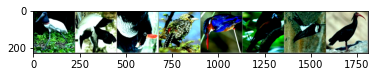

Label: 0 3 3 0 1 0 3 0
Pred_: 0 3 3 0 1 0 1 0


In [15]:
show_img(model_ft, 8)